In [8]:
import pandas as pd
import numpy as np
import os
import matplotlib as plt
%matplotlib inline
exec(open(os.path.join(os.environ["SPARK_HOME"], 'python/pyspark/shell.py')).read())

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 2.4.4
      /_/

Using Python version 3.7.4 (default, Aug 13 2019 15:17:50)
SparkSession available as 'spark'.


In [9]:
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkFiles
from pyspark.sql import DataFrameReader
from pyspark.sql.functions import to_timestamp
from pyspark.sql.functions import col
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
from pyspark.sql.types import *

In [10]:
spark = SparkSession \
    .builder \
    .appName('pyspark_demo_app') \
    .config('spark.driver.extraClassPath',
            'postgresql-42.2.9') \
    .master("local[*]") \
    .getOrCreate()

In [11]:
# tips on jdbc ... https://sparkour.urizone.net/recipes/using-jdbc/#03
# Load properties from file
import json
with open("../data-load/Resources/db-properties.json") as propertyFile:
    properties = json.load(propertyFile)

dbMode = "overwrite"
jdbc_url= properties["jdbcUrl"]
dbConfig = {"user": properties["user"], 
          "password": properties["password"], 
          "driver": properties["driver"]
         }

In [12]:
entireDF = spark.read.jdbc(url=jdbc_url, table = 'heart_ml_cleveland', properties=dbConfig)
entireDF.printSchema()
entireDF.limit(5).show()

root
 |-- age: double (nullable = true)
 |-- sex: double (nullable = true)
 |-- cp: double (nullable = true)
 |-- trestbps: double (nullable = true)
 |-- chol: double (nullable = true)
 |-- fbs: double (nullable = true)
 |-- restecg: double (nullable = true)
 |-- thalach: double (nullable = true)
 |-- exang: double (nullable = true)
 |-- oldpeak: double (nullable = true)
 |-- slope: double (nullable = true)
 |-- ca: double (nullable = true)
 |-- thal: double (nullable = true)
 |-- num: integer (nullable = true)

+----+---+---+--------+-----+---+-------+-------+-----+-------+-----+---+----+---+
| age|sex| cp|trestbps| chol|fbs|restecg|thalach|exang|oldpeak|slope| ca|thal|num|
+----+---+---+--------+-----+---+-------+-------+-----+-------+-----+---+----+---+
|63.0|1.0|1.0|   145.0|233.0|1.0|    2.0|  150.0|  0.0|    2.3|  3.0|0.0| 6.0|  0|
|67.0|1.0|4.0|   160.0|286.0|0.0|    2.0|  108.0|  1.0|    1.5|  2.0|3.0| 3.0|  2|
|67.0|1.0|4.0|   120.0|229.0|0.0|    2.0|  129.0|  1.0|    2.6|  2.

In [13]:
#convert to pandas df
heart_ml_df = entireDF.select("*").toPandas()
heart_ml_df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,52.0,1.0,4.0,128.0,204.0,1.0,0.0,156.0,1.0,1.0,2.0,0.0,NaN,2
299,52.0,1.0,3.0,138.0,223.0,0.0,0.0,169.0,0.0,0.0,1.0,NaN,3.0,0
300,43.0,1.0,4.0,132.0,247.0,1.0,2.0,143.0,1.0,0.1,2.0,NaN,7.0,1
301,58.0,1.0,2.0,125.0,220.0,0.0,0.0,144.0,0.0,0.4,2.0,NaN,7.0,0


# Data-preprocessing

In [63]:
#Age: displays the age of the individual.
# Sex: displays the gender of the individual using the following format :
# 1 = male
# 0 = female
# Chest-pain type: displays the type of chest-pain experienced by the individual using the following format :
# 1 = typical angina
# 2 = atypical angina
# 3 = non — anginal pain
# 4 = asymptotic
# Resting Blood Pressure: displays the resting blood pressure value of an individual in mmHg (unit)
# Serum Cholestrol: displays the serum cholesterol in mg/dl (unit)
# Fasting Blood Sugar: compares the fasting blood sugar value of an individual with 120mg/dl.
# If fasting blood sugar > 120mg/dl then : 1 (true)
# else : 0 (false)
# Resting ECG : displays resting electrocardiographic results
# 0 = normal
# 1 = having ST-T wave abnormality
# 2 = left ventricular hyperthrophy
# Max heart rate achieved : displays the max heart rate achieved by an individual.
# Exercise induced angina :
# 1 = yes
# 0 = no
# ST depression induced by exercise relative to rest: displays the value which is an integer or float.
# Peak exercise ST segment :
# 1 = upsloping
# 2 = flat
# 3 = downsloping
# ca: Number of major vessels (0–3) colored by flourosopy : displays the value as integer or float.
# Thal : displays the thalassemia :
# 3 = normal
# 6 = fixed defect
# 7 = reversible defect
# Diagnosis of heart disease : Displays whether the individual is suffering from heart disease or not :
# 0 = absence
# 1, 2, 3, 4 = present.


In [64]:
#pip install pandas-profiling[notebook,html]
import pandas_profiling as pp
from pandas_profiling import ProfileReport

In [65]:
#EDA with pandas profiling(https://github.com/pandas-profiling/pandas-profiling)
profile=ProfileReport(heart_ml_df, title='Pandas Profiling Report for cleveland dataset',  html={'style':{'full_width':True}})
profile.to_notebook_iframe()

In [66]:
#Saveing profileReport
profile.to_file(output_file="cleveland_profile_report.html")

In [7]:
#1)Drop null values and build model to check accuracy
#2)Impute and build to check accuracy
heart_ml_df=heart_ml_df.dropna()
heart_ml_df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,57.0,0.0,4.0,140.0,241.0,0.0,0.0,123.0,1.0,0.2,2.0,0.0,7.0,1
293,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1
294,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,2
295,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,3


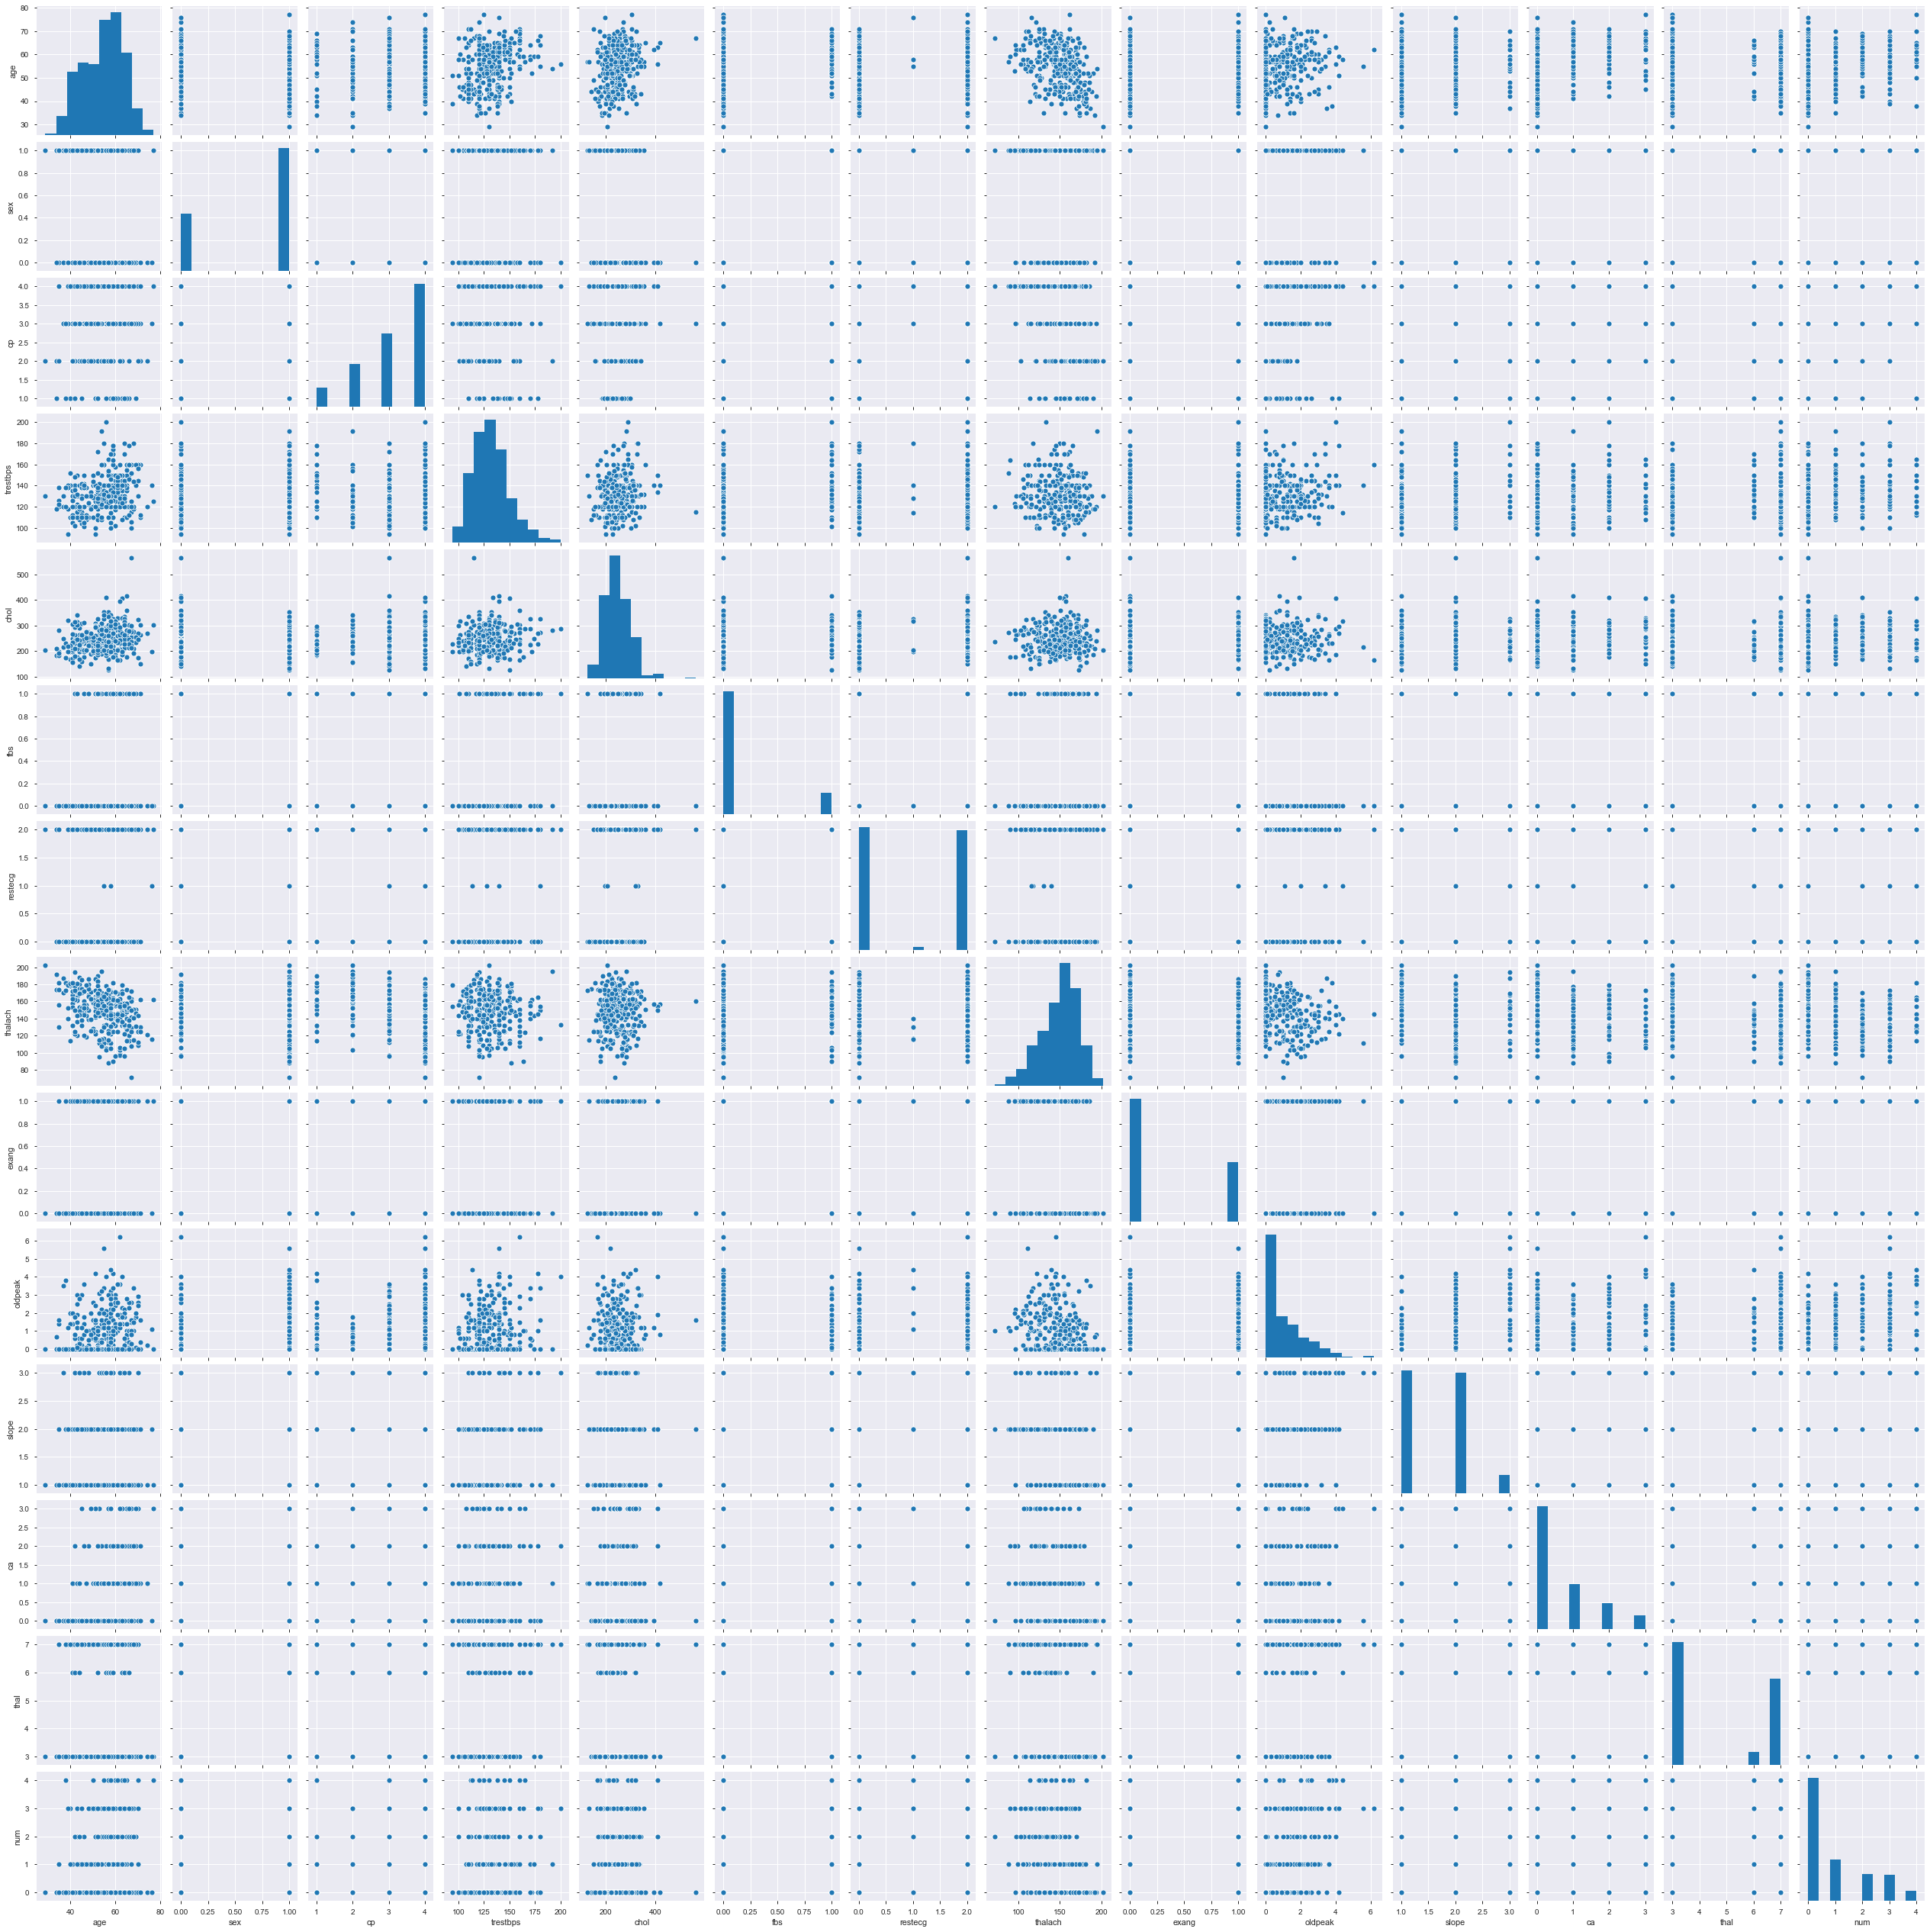

In [102]:
import seaborn as sns
sns.pairplot(data=heart_ml_df)

In [12]:
heart_ml_df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
num         0
dtype: int64

In [29]:
target = heart_ml_df["num"]
data = heart_ml_df.drop("num", axis=1)
feature_names = data.columns
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0


In [91]:
#Check distribution of datapoints in categorical label
np.bincount(target)

array([160,  54,  35,  35,  13])

In [94]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)
X_train.info()
# X_test.count()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 237 entries, 273 to 102
Data columns (total 13 columns):
age         237 non-null float64
sex         237 non-null float64
cp          237 non-null float64
trestbps    237 non-null float64
chol        237 non-null float64
fbs         237 non-null float64
restecg     237 non-null float64
thalach     237 non-null float64
exang       237 non-null float64
oldpeak     237 non-null float64
slope       237 non-null float64
ca          237 non-null float64
thal        237 non-null float64
dtypes: float64(13)
memory usage: 25.9 KB


In [101]:
# #Check distribution of datapoints in categorical label after splitting to see if proportion is maintained
np.bincount(y_train)

array([124,  45,  30,  28,  10])

In [86]:
# from sklearn.preprocessing import StandardScaler as ss
# sc = ss()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.fit_transform(X_test)

In [87]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf')
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

from sklearn.metrics import confusion_matrix
cm_test = confusion_matrix(y_pred, y_test)

y_pred_train = classifier.predict(X_train)
cm_train = confusion_matrix(y_pred_train, y_train)

print()
print('Accuracy for training set for svm = {}'.format((cm_train[0][0] + cm_train[1][1])/len(y_train)))
print('Accuracy for test set for svm = {}'.format((cm_test[0][0] + cm_test[1][1])/len(y_test)))



Accuracy for training set for svm = 0.5738396624472574
Accuracy for test set for svm = 0.6166666666666667


## LogisticRegression

In [88]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
# Create an instance of Logistic Regression Classifier and fit the data.
logreg.fit(X_train,y_train)
lg_score=round(logreg.score(X_train,y_train)*100,22)
lg_score

63.29113924050633

In [84]:
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)


# Predicting the Test set results
y_pred = classifier.predict(X_test)

from sklearn.metrics import confusion_matrix
cm_test = confusion_matrix(y_pred, y_test)

y_pred_train = classifier.predict(X_train)
cm_train = confusion_matrix(y_pred_train, y_train)

print()
print('Accuracy for training set for Naive Bayes = {}'.format((cm_train[0][0] + cm_train[1][1])/len(y_train)))
print('Accuracy for test set for Naive Bayes = {}'.format((cm_test[0][0] + cm_test[1][1])/len(y_test)))



Accuracy for training set for Naive Bayes = 0.42342342342342343
Accuracy for test set for Naive Bayes = 0.5066666666666667


In [42]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 10)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

from sklearn.metrics import confusion_matrix
cm_test = confusion_matrix(y_pred, y_test)

y_pred_train = classifier.predict(X_train)
cm_train = confusion_matrix(y_pred_train, y_train)

print()
print('Accuracy for training set for Random Forest = {}'.format((cm_train[0][0] + cm_train[1][1])/len(y_train)))
print('Accuracy for test set for Random Forest = {}'.format((cm_test[0][0] + cm_test[1][1])/len(y_test)))


Accuracy for training set for Random Forest = 0.7117117117117117
Accuracy for test set for Random Forest = 0.5333333333333333


# Neural Network

In [1]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
import keras
from keras.models import Sequential
from keras.layers import Dense
import warnings

Using TensorFlow backend.
/Users/harmeetkaur/anaconda3/envs/pythondata/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/harmeetkaur/anaconda3/envs/pythondata/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/harmeetkaur/anaconda3/envs/pythondata/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.in

# Label encoding, create dummy variables

In [2]:
chest_pain=pd.get_dummies(heart_ml_df['cp'],prefix='cp',drop_first=True)
heart_ml_df=pd.concat([heart_ml_df,chest_pain],axis=1)
heart_ml_df.drop(['cp'],axis=1,inplace=True)
sp=pd.get_dummies(heart_ml_df['slope'],prefix='slope')
th=pd.get_dummies(heart_ml_df['thal'],prefix='thal')
rest_ecg=pd.get_dummies(heart_ml_df['restecg'],prefix='restecg')
frames=[df,sp,th,rest_ecg]
heart_ml_df=pd.concat(frames,axis=1)
heart_ml_df.drop(['slope','thal','restecg'],axis=1,inplace=True)

NameError: name 'pd' is not defined